In [150]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import make_scorer,fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.utils import resample

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import importlib

# from eda_functions import data_exploration, draw_histogram, draw_countplot
import eda_functions as ef
importlib.reload(ef)
print()


In [12]:
SEED = 0

pd.set_option('display.max_colwidth', None, 
              'display.max_columns', None,
              'display.max_rows', None)


In [217]:

def get_scores(model, X_test, y_test):
    # Print the different scores
    y_pred = model.predict(X_test.values)   # add .values to avoir error and warnings
    print("   accuracy: ", round(accuracy_score(y_test, y_pred), 3))
    print("   AUC: ", round(roc_auc_score(y_test, y_pred), 3))
    print("   precision: ", round(precision_score(y_test,y_pred), 3))
    print("   recall: ", round(recall_score(y_test,y_pred), 3))
    print("   f1: ", round(f1_score(y_test, y_pred), 3))
    # print("   ", confusion_matrix(y_test, y_pred))
    f, ax = plt.subplots(figsize=(2, 2))
    cmap = sns.diverging_palette(180, 180, as_cmap=True)
    sns.heatmap(confusion_matrix(y_test, y_pred),  vmax=.9, center=0, fmt='.0f',  cmap=cmap, # mask=mask, 
                       square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True) #True)
    plt.show()

    
def fit_score_model(model, X_train, y_train, X_test, y_test, title):
    # Fit a model to the training data and print the scores
    model.fit(X_train.values, y_train)
    print('\n--- ' + title + ' Model ---')
    print('Scores on the train set:')
    get_scores(model, X_train, y_train)
    print('Scores on the test set:')
    get_scores(model, X_test, y_test)
    return model

def run_kfold(model, X_train, y_train, title):
    scores = []
    cv = KFold(n_splits=10, random_state=SEED, shuffle=True)   # tc params

    for train_index, valid_index in cv.split(X_train):
        # print("Index du train : ", train_index)
        # print("Index de validation : ", valid_index, "\n")
        X_train2, X_valid, y_train2, y_valid = (
            X_train.iloc[train_index], X_train.iloc[valid_index], 
            y_train.iloc[train_index], y_train.iloc[valid_index] )
        model.fit(X_train2.values, y_train2)
        y_pred = model.predict(X_valid.values)
        scores.append(round(f1_score(y_valid, y_pred), 3))
    print('--- ' + title + ' Model (F1 score) ---')
    print('   ', scores)
    print('   ', round(np.mean(scores),3), '+/-', round(np.std(scores),3), '\n')
    return model

def draw_histograms(data, logx=False, logy=False):
    # Check the distribution of the values (and potential outliers or errors)
    # fig, ax = plt.subplots(figsize=(2, 20))
    # data0.plot.hist(subplots=True, legend=False, layout=(32, 3), ax=ax)
    # plt.show()
    for col in data.columns: 
        fig, ax = plt.subplots(figsize=(15, 2))
        data[col].plot.hist(legend=True, bins=200, logx = logx, logy=logy)
        plt.show()
        

In [14]:
# Get the data

data0 = pd.read_csv('brfss2021_cleaned.csv')
data0.drop(['Unnamed: 0'], axis=1, inplace=True)
print(data0.shape)

(272753, 28)


In [ ]:
categorical_columns = [
    'state_id', 'sex', 'general_health', 'med_cost_issue', 'physical_activity', 'blood_pressure',
    'cholesterol', 'stroke', 'asthma', 'depression', 'diabete', 'arthritis', 'education', 'veteran', 
    'income', 'smoked_100_cig', 'is_urban', 'race', 'age', 'bmi', 'cvd', 'cancer'
]
for col in categorical_columns:
    data0[col] = data0[col].astype('category')


In [15]:
# Correlations

# As most of the features are categorical, the 5 numericalfeatures are binned to become categorical
# so that the statistical method Cramer-V can be used to study the "correlations" between the features

data2 = data0.copy()
data2['fruits'] = pd.cut(x=data2['fruits'], bins=2*15) #bins=list(range(1, 16)))
data2['vegetables'] = pd.cut(x=data2['vegetables'], bins=2*20)
data2['alcohol'] = pd.cut(x=data2['alcohol'], bins=2*8)
data2['weight'] = pd.cut(x=data2['weight'], bins=35)
data2['height'] = pd.cut(x=data2['height'], bins=17)  #16
display(data2.head())


,Unnamed: 0,state_id,sex,general_health,med_cost_issue,physical_activity,blood_pressure,cholesterol,stroke,asthma,depression,diabete,arthritis,education,veteran,income,weight,height,smoked_100_cig,is_urban,race,age,bmi,alcohol,fruits,vegetables,cvd,cancer
0,1,1,F,2.0,no,no,yes,no,no,no,no,yes,no,high-school,no,15-20k,"(74.999, 79.999]","(1.614, 1.666]",no,yes,black,72.0,overweight,"(-0.008, 0.5]","(0.5, 1.0]","(0.5, 1.0]",1,0
1,2,1,F,2.0,no,yes,yes,yes,no,no,no,yes,no,high-school,no,50-75k,"(84.999, 89.999]","(1.614, 1.666]",no,yes,white,62.0,obese,"(-0.008, 0.5]","(1.0, 1.5]","(1.5, 2.0]",0,0
2,3,1,M,3.0,no,no,no,no,no,no,no,no,no,some college,no,35-50k,"(84.999, 89.999]","(1.875, 1.927]",yes,no,white,82.0,normalweight,"(-0.008, 0.5]","(-0.015, 0.5]","(-0.02, 0.5]",0,0
3,4,1,M,3.0,no,no,yes,no,no,no,yes,no,yes,college,no,100-150k,"(149.998, 154.997]","(1.823, 1.875]",no,yes,white,62.0,obese,"(-0.008, 0.5]","(-0.015, 0.5]","(1.0, 1.5]",0,0
4,5,1,M,4.0,no,yes,yes,yes,no,no,no,no,yes,some high-school,no,<10k,"(65.0, 69.999]","(1.718, 1.77]",yes,yes,white,62.0,normalweight,"(-0.008, 0.5]","(0.5, 1.0]","(1.0, 1.5]",1,0


In [16]:
ef.data_exploration(data2)

,Unnamed: 0,state_id,sex,general_health,med_cost_issue,physical_activity,blood_pressure,cholesterol,stroke,asthma,depression,diabete,arthritis,education,veteran,income,weight,height,smoked_100_cig,is_urban,race,age,bmi,alcohol,fruits,vegetables,cvd,cancer
0,1,1,F,2.0,no,no,yes,no,no,no,no,yes,no,high-school,no,15-20k,"(74.999, 79.999]","(1.614, 1.666]",no,yes,black,72.0,overweight,"(-0.008, 0.5]","(0.5, 1.0]","(0.5, 1.0]",1,0
1,2,1,F,2.0,no,yes,yes,yes,no,no,no,yes,no,high-school,no,50-75k,"(84.999, 89.999]","(1.614, 1.666]",no,yes,white,62.0,obese,"(-0.008, 0.5]","(1.0, 1.5]","(1.5, 2.0]",0,0
2,3,1,M,3.0,no,no,no,no,no,no,no,no,no,some college,no,35-50k,"(84.999, 89.999]","(1.875, 1.927]",yes,no,white,82.0,normalweight,"(-0.008, 0.5]","(-0.015, 0.5]","(-0.02, 0.5]",0,0
3,4,1,M,3.0,no,no,yes,no,no,no,yes,no,yes,college,no,100-150k,"(149.998, 154.997]","(1.823, 1.875]",no,yes,white,62.0,obese,"(-0.008, 0.5]","(-0.015, 0.5]","(1.0, 1.5]",0,0
4,5,1,M,4.0,no,yes,yes,yes,no,no,no,no,yes,some high-school,no,<10k,"(65.0, 69.999]","(1.718, 1.77]",yes,yes,white,62.0,normalweight,"(-0.008, 0.5]","(0.5, 1.0]","(1.0, 1.5]",1,0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272753 entries, 0 to 272752
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Unnamed: 0         272753 non-null  int64   
 1   state_id           272753 non-null  int64   
 2   sex                272753 non-null  object  
 3   general_health     272753 non-null  float64 
 4   med_cost_issue     272753 non-null  object  
 5   physical_activity  272753 non-null  object  
 6   blood_pressure     272753 non-null  object  
 7   cholesterol        272753 non-null  object  
 8   stroke             272753 non-null  object  
 9   asthma             272753 non-null  object  
 10  depression         272753 non-null  object  
 11  diabete            272753 non-null  object  
 12  arthritis          272753 non-null  object  
 13  education          272753 non-null  object  
 14  veteran            272753 non-null  object  
 15  income             272753 non-nul

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,272753.0,NaN,NaN,NaN,137735.451658,79525.540835,1.0,68914.0,137604.0,206633.0,275438.0
state_id,272753.0,NaN,NaN,NaN,30.901471,15.612541,1.0,20.0,31.0,42.0,78.0
sex,272753,2,F,145512,NaN,NaN,NaN,NaN,NaN,NaN,NaN
general_health,272753.0,NaN,NaN,NaN,2.490543,1.032448,1.0,2.0,2.0,3.0,5.0
med_cost_issue,272753,2,no,255890,NaN,NaN,NaN,NaN,NaN,NaN,NaN
physical_activity,272753,2,yes,211210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
blood_pressure,272753,2,no,152582,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cholesterol,272753,2,no,162530,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stroke,272753,2,no,261907,NaN,NaN,NaN,NaN,NaN,NaN,NaN
asthma,272753,2,no,234607,NaN,NaN,NaN,NaN,NaN,NaN,NaN


C:\Users\PC\AppData\Local\Temp\ipykernel_1808\1908969857.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\PC\AppData\Local\Temp\ipykernel_1808\1908969857.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\PC\AppData\Local\Temp\ipykernel_1808\1908969857.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\PC\AppData\Local\Temp\ipykernel_1808\1908969857.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\PC\AppData\Local\Temp\ipykernel_1808\1908969857.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\PC\AppData\Local\Temp\ipykernel_1808\1908969857.py:31: RuntimeWarning: divide by zero encountered in

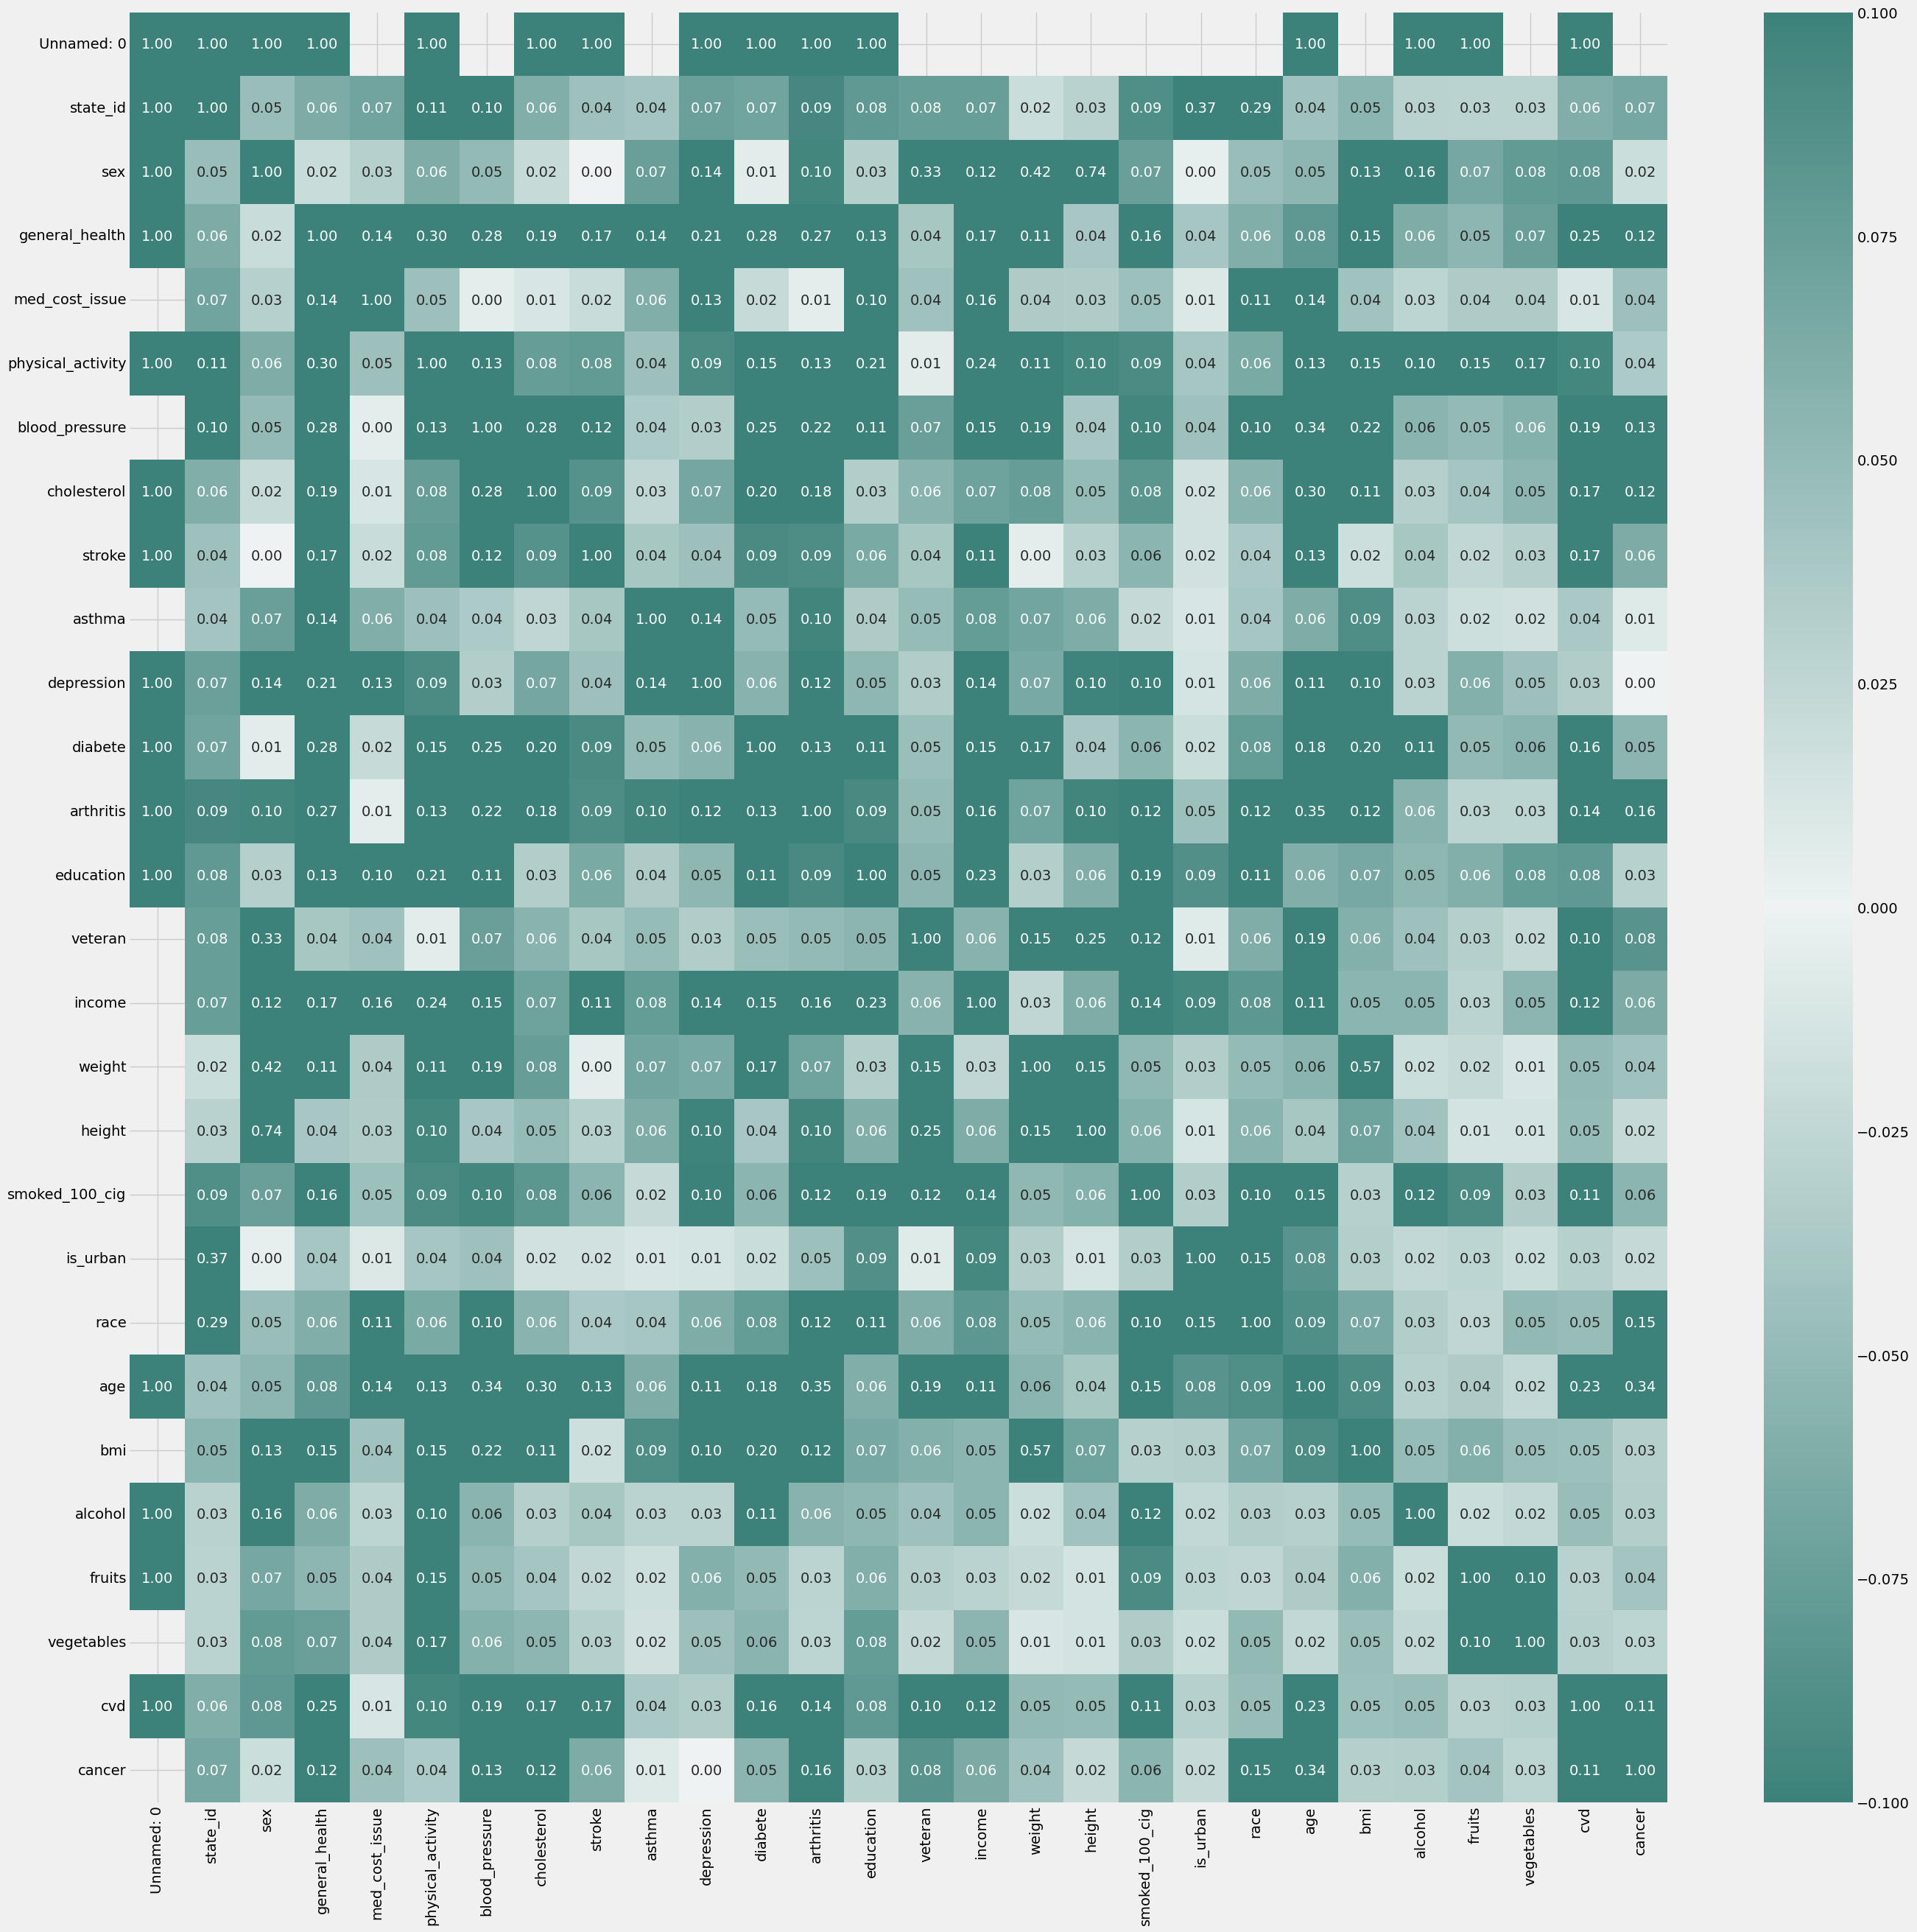

In [17]:
# Heatmap with the Cramer-V coefficients
# This cell is from stackoverflow

from itertools import combinations
from scipy.stats import chi2_contingency
import scipy.stats as ss
import seaborn as sns
def get_corr_mat(df, f=chi2_contingency):
        columns = df.columns
        dm = pd.DataFrame(index=columns, columns=columns)
        for var1, var2 in combinations(columns, 2):
            cont_table = pd.crosstab(df[var1], df[var2], margins=False)
            chi2_stat = cramers_v(cont_table.values)
            dm.loc[var2, var1] = chi2_stat
            dm.loc[var1, var2] = chi2_stat
        dm.fillna(1, inplace=True)
        return dm

def cramers_v(confusion_matrix):
        """ calculate Cramers V statistic for categorial-categorial association.
            uses correction from Bergsma and Wicher,
            Journal of the Korean Statistical Society 42 (2013): 323-328
        """
        chi2 = ss.chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

    
# cat_corr= get_corr_mat(data1[categorical_columns])
cat_corr = get_corr_mat(data2)
fig, ax = plt.subplots(figsize=(30,30))
cmap = sns.diverging_palette(180, 180, as_cmap=True)
sns.heatmap(cat_corr, annot = True, fmt='.2f')#, cmap=cmap)
plt.show()


Index(['Unnamed: 0', 'state_id', 'sex', 'general_health', 'med_cost_issue',
       'physical_activity', 'blood_pressure', 'cholesterol', 'stroke',
       'asthma', 'depression', 'diabete', 'arthritis', 'education', 'veteran',
       'income', 'weight', 'height', 'smoked_100_cig', 'is_urban', 'race',
       'age', 'bmi', 'alcohol', 'fruits', 'vegetables', 'cvd', 'cancer'],
      dtype='object')


,state_id,sex,general_health,med_cost_issue,physical_activity,blood_pressure,cholesterol,stroke,asthma,depression,diabete,arthritis,education,veteran,income,weight,height,smoked_100_cig,is_urban,race,age,bmi,alcohol,fruits,vegetables,cvd,cancer
state_id,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.370433,0.292992,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000
sex,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.328406,0.0,0.415426,0.740586,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000
general_health,0.000000,0.000000,1.000000,0.0,0.295612,0.278325,0.000000,0.0,0.0,0.0,0.281628,0.265659,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.25128,0.000000
med_cost_issue,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000
physical_activity,0.000000,0.000000,0.295612,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000
blood_pressure,0.000000,0.000000,0.278325,0.0,0.000000,1.000000,0.279682,0.0,0.0,0.0,0.251408,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.339583,0.000000,0.0,0.0,0.0,0.00000,0.000000
cholesterol,0.000000,0.000000,0.000000,0.0,0.000000,0.279682,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.297133,0.000000,0.0,0.0,0.0,0.00000,0.000000
stroke,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000
asthma,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000
depression,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000


Unnamed: 0           1.000000
cvd                  1.000000
general_health       0.251280
age                  0.226680
blood_pressure       0.192921
stroke               0.174843
cholesterol          0.166678
diabete              0.160697
arthritis            0.143261
income               0.121496
cancer               0.108220
smoked_100_cig       0.107786
veteran              0.104659
physical_activity    0.096007
sex                  0.080229
education            0.079620
state_id             0.060713
weight               0.051232
height               0.049224
race                 0.047914
alcohol              0.047473
bmi                  0.045860
asthma               0.038196
depression           0.034195
vegetables           0.031234
is_urban             0.030851
fruits               0.029355
med_cost_issue       0.011929
Name: cvd, dtype: float64

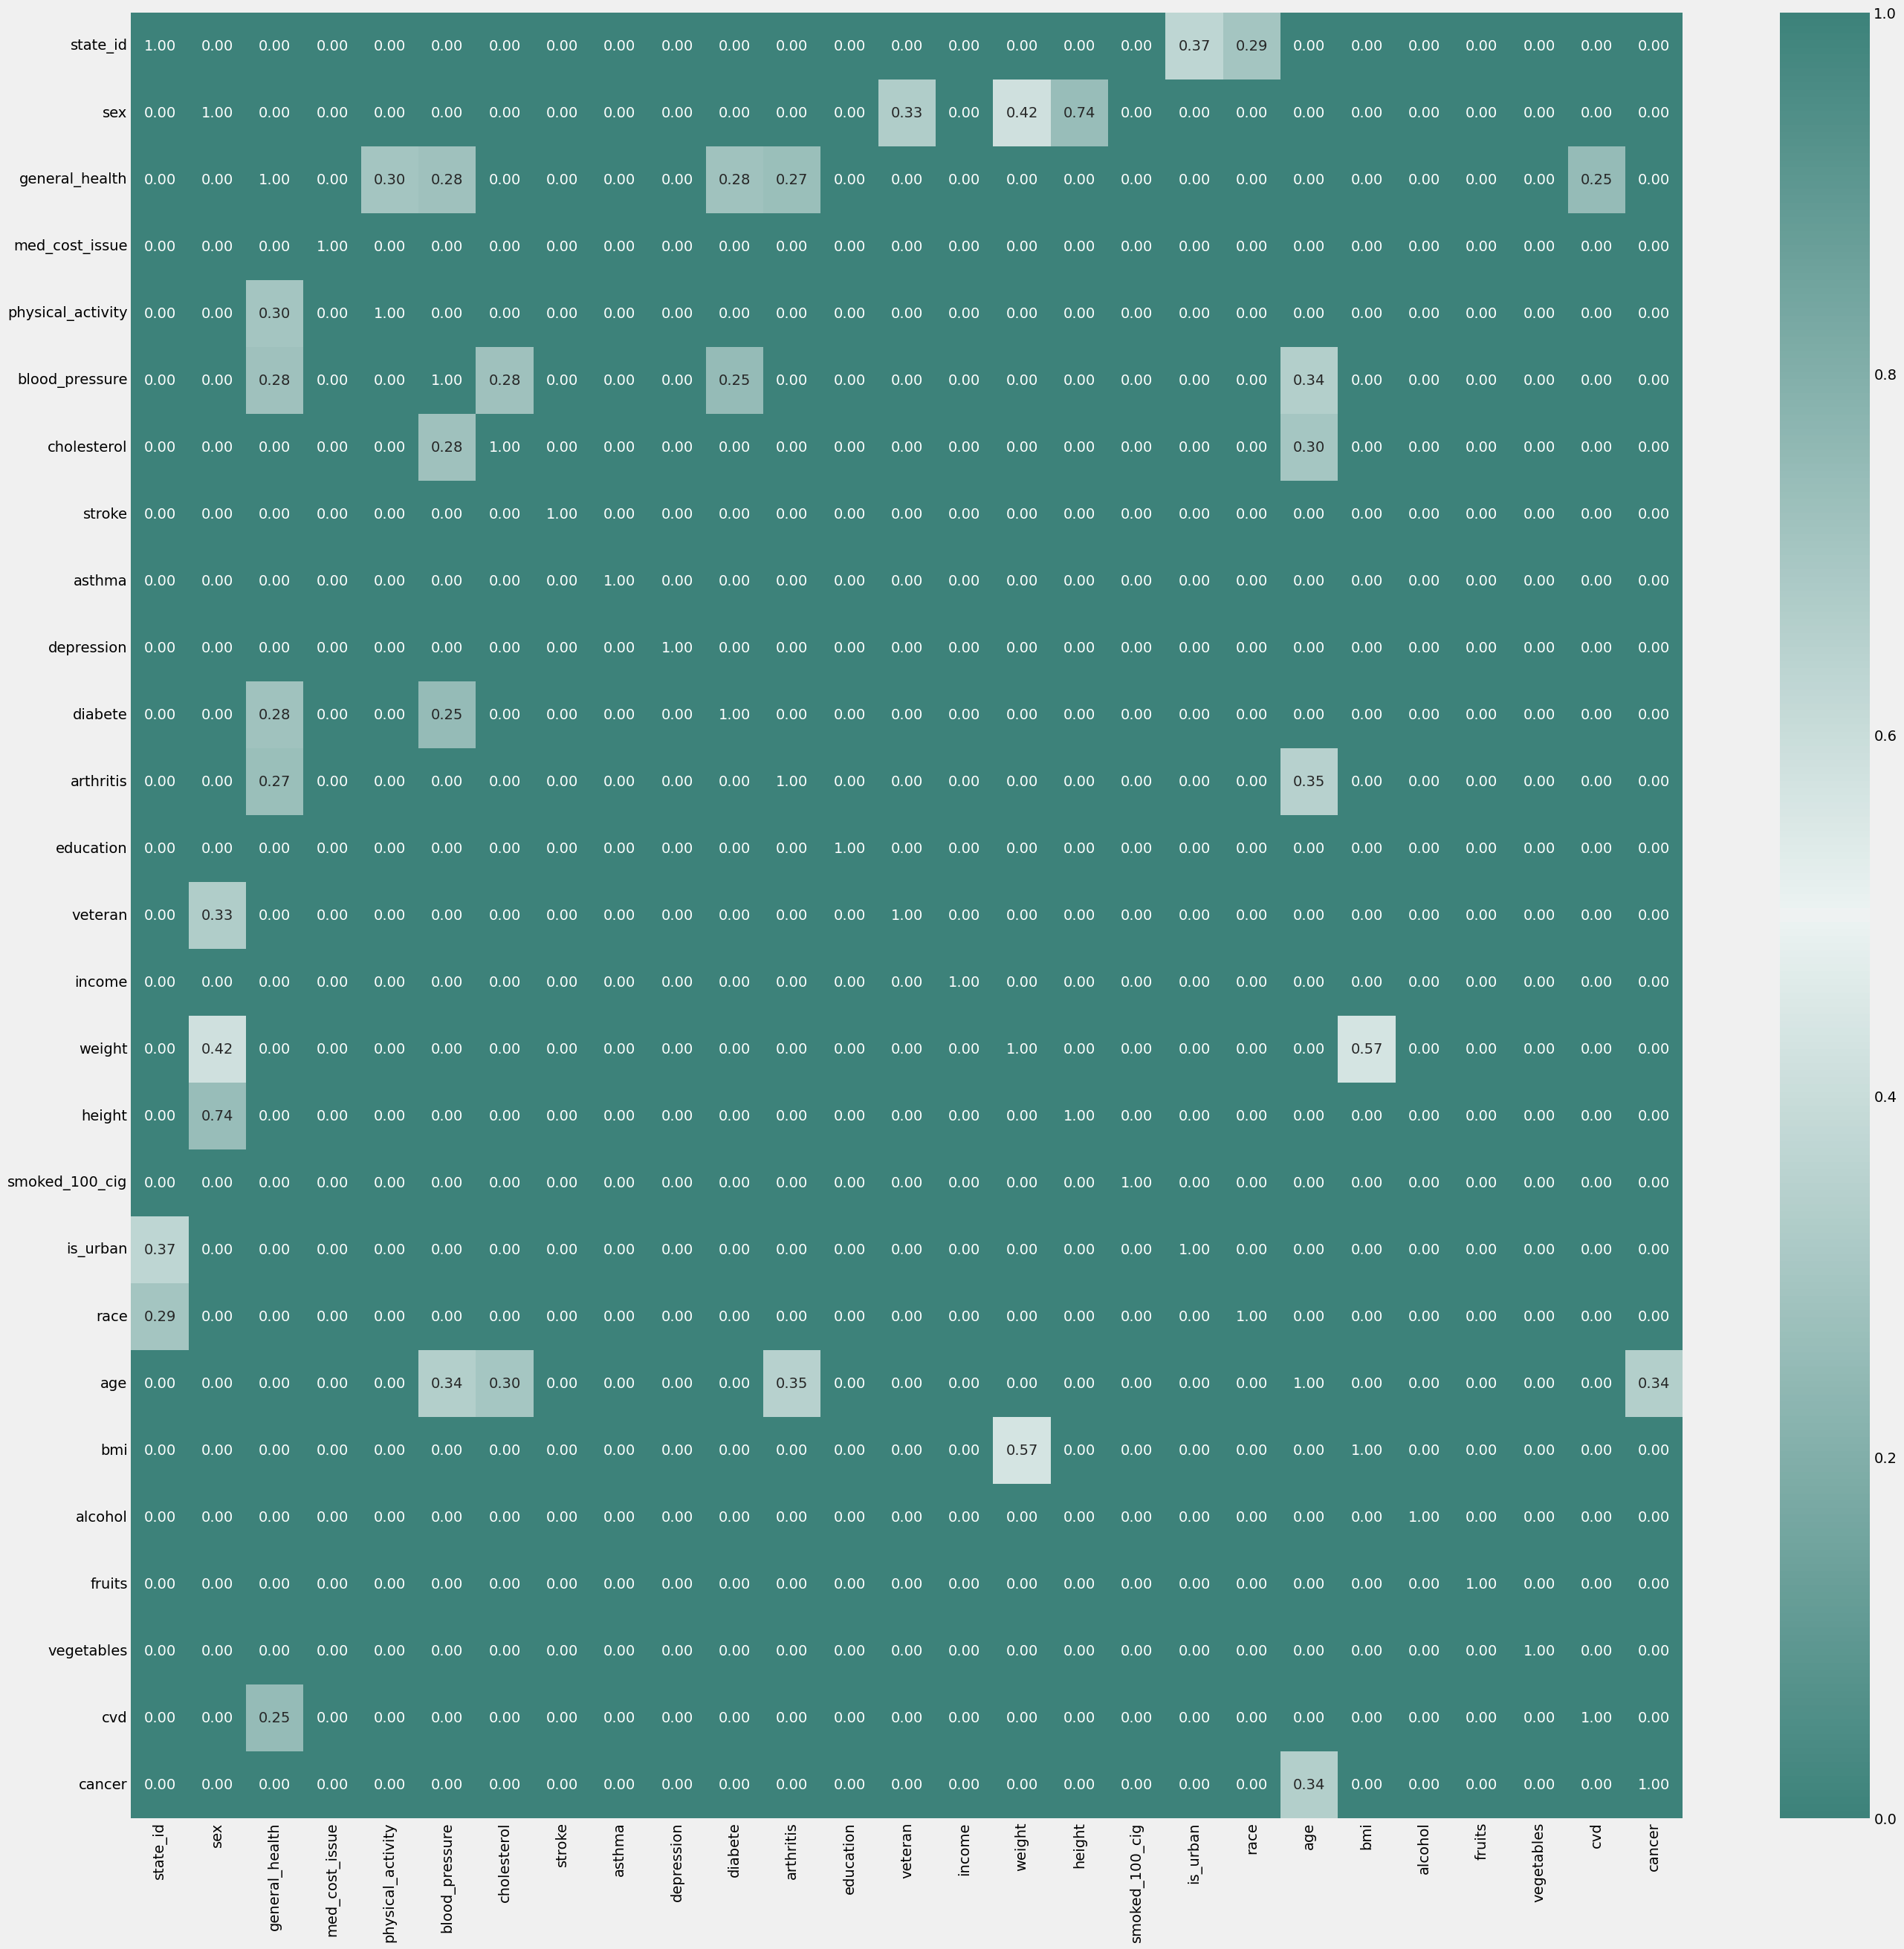

In [26]:
# Removal of the features not correlated to the target (<0.1)
print(data0.columns)
display(cat_corr['cvd'].sort_values(ascending=False))

# Display the largest Cramer-V coefficients
fig, ax = plt.subplots(figsize=(30,30))
cmap = sns.diverging_palette(180, 180, as_cmap=True)
sns.heatmap(cat_corr[cat_corr > 0.25].iloc[1:, 1:].fillna(0),   ######### remove 1, 1: if no column unnamed
            annot = True, fmt='.2f')#, cmap=cmap)
plt.show()

In [202]:
chosen_cols = [   # remove age as it is correlated to several variables?
       'physical_activity', 'blood_pressure', 'cholesterol', 'stroke',
       'diabete', 'arthritis', 'veteran', 'income', 'smoked_100_cig', 
       'age', 'cancer', 'cvd',
       'sex',
]
# chosen_cols = ['sex', 'is_urban', 'med_cost_issue', 'state_id', 
#        'physical_activity', 'blood_pressure', 'cholesterol', 'stroke',
#        'asthma', 'depression', 'diabete', 'arthritis', 'education', 'veteran',
#        'income', 'weight', 'height', 'smoked_100_cig',  'race',
#        'age', 'bmi', 'cvd', 'cancer', 'alcohol', 'fruits', 'vegetables', ]  
# 'general_health' -> target leaking

# chosen_cols = data0.columns

yesno_cols = [ 
       'physical_activity', 'blood_pressure', 'cholesterol', 'stroke',
       'diabete', 'arthritis', 'veteran', 'smoked_100_cig', 
]

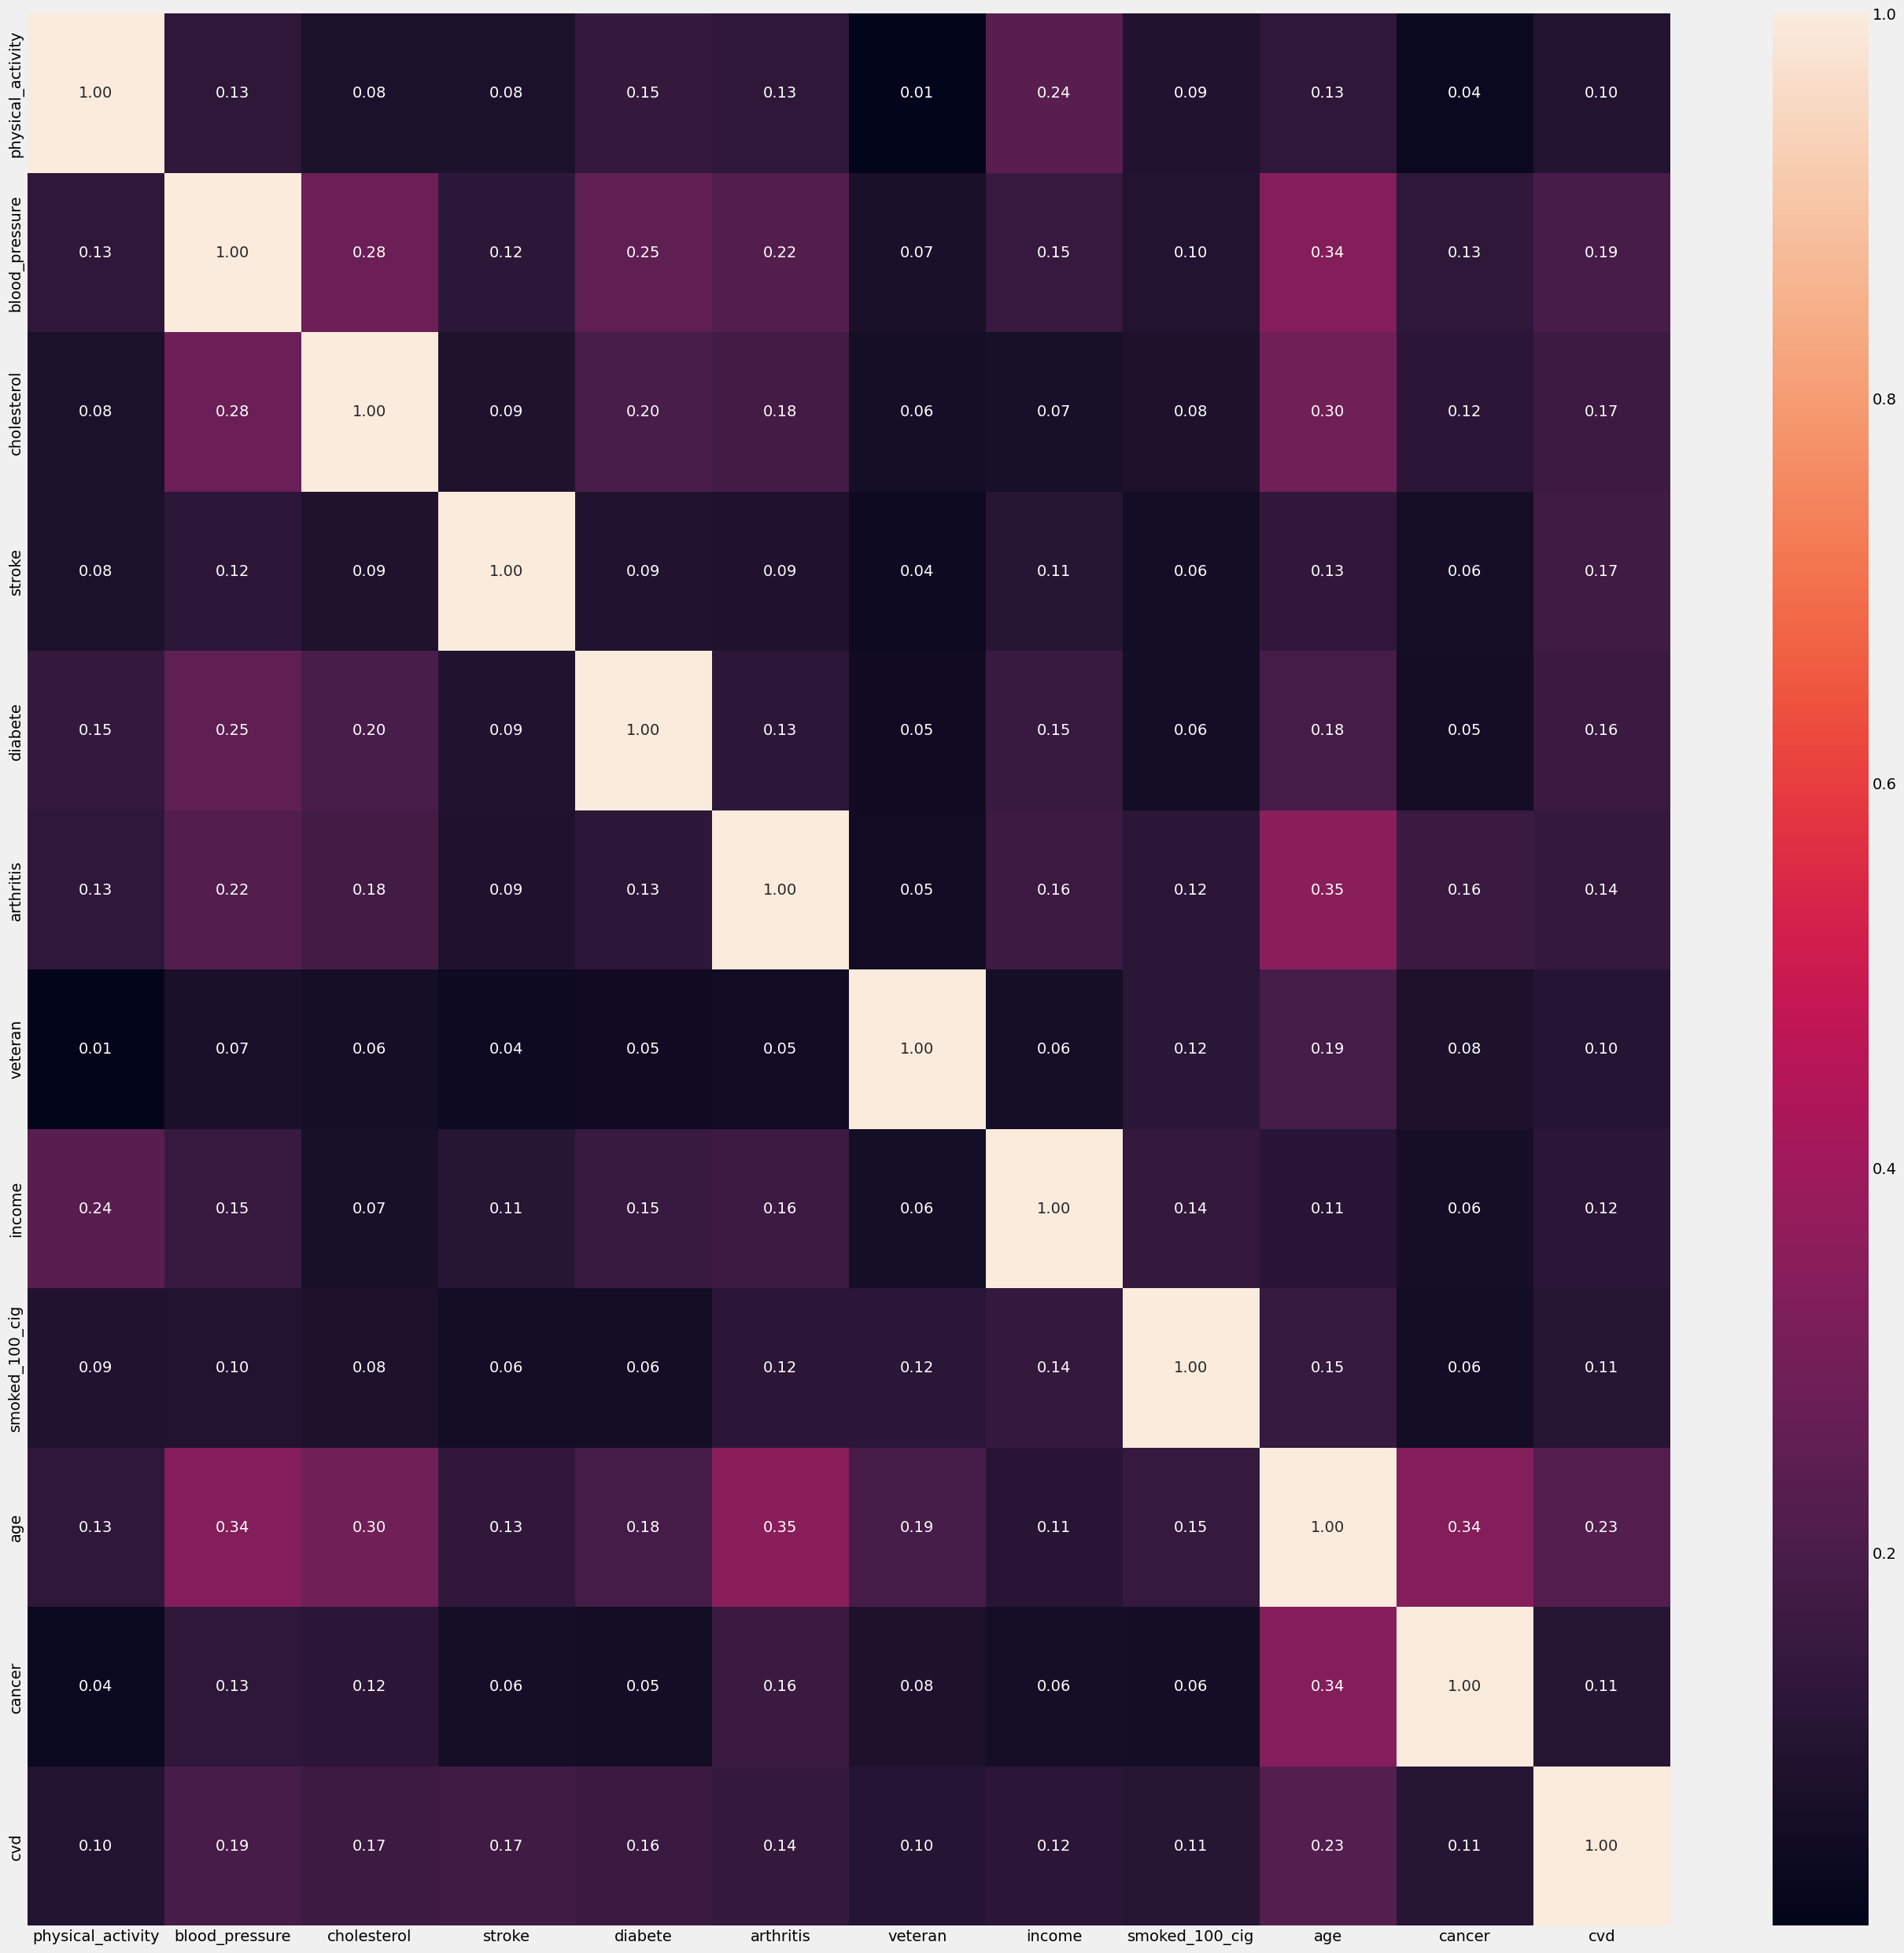

In [30]:
# Correlation on chosen columns

cat_corr2 = get_corr_mat(data2[chosen_cols])
fig, ax = plt.subplots(figsize=(30,30))
# cmap = sns.diverging_palette(180, 180, as_cmap=True)
sns.heatmap(cat_corr2, annot = True, fmt='.2f')#, cmap=cmap)
plt.show()

In [203]:
# Transform the data from categorical to numerical

data1 = data0.copy()
data1.replace({'yes':1, 'no':0}, inplace=True)

data1['income'] = data1['income'].replace({'<10k':1, '10-15k':2, '15-20k':3, '20-25k':4, '25-35k':5,
                                           '35-50k':6, '50-75k':7, '75-100k':8, '100-150k':9, 
                                           '150-200k':10, '>200k':11})
data1['age'] = data1['age'].astype('int')

if 'sex' in chosen_cols:
    data1['sex'] = data1['sex'].replace({'M':1, 'F':0})
    
if 'education' in chosen_cols:
    data1['education'] = data1['education'].replace({'kindergarten':1, 'elementary':2, 'some high-school':3,
                                                     'high-school':4, 'some college':5, 'college':6})

tzip = zip(['white', 'black', 'indian', 'asian', 'hawaiian', 
            'other', 'multiracial', 'hispanic'], [i + 1 for i in range(8)])
if 'race' in chosen_cols:  
    data1['race'] = data1['race'].replace(dict(tzip))

if 'bmi' in chosen_cols:  
    data1['bmi'] = data1['bmi'].replace({'underweight':1, 'normalweight':2, 'overweight':3, 'obese':4})

# for col in chosen_cols:
#     print('\n', data1[col].value_counts())


C:\Users\PC\AppData\Local\Temp\ipykernel_1808\1402699185.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix_num = data1[chosen_cols].corr(method='spearman')


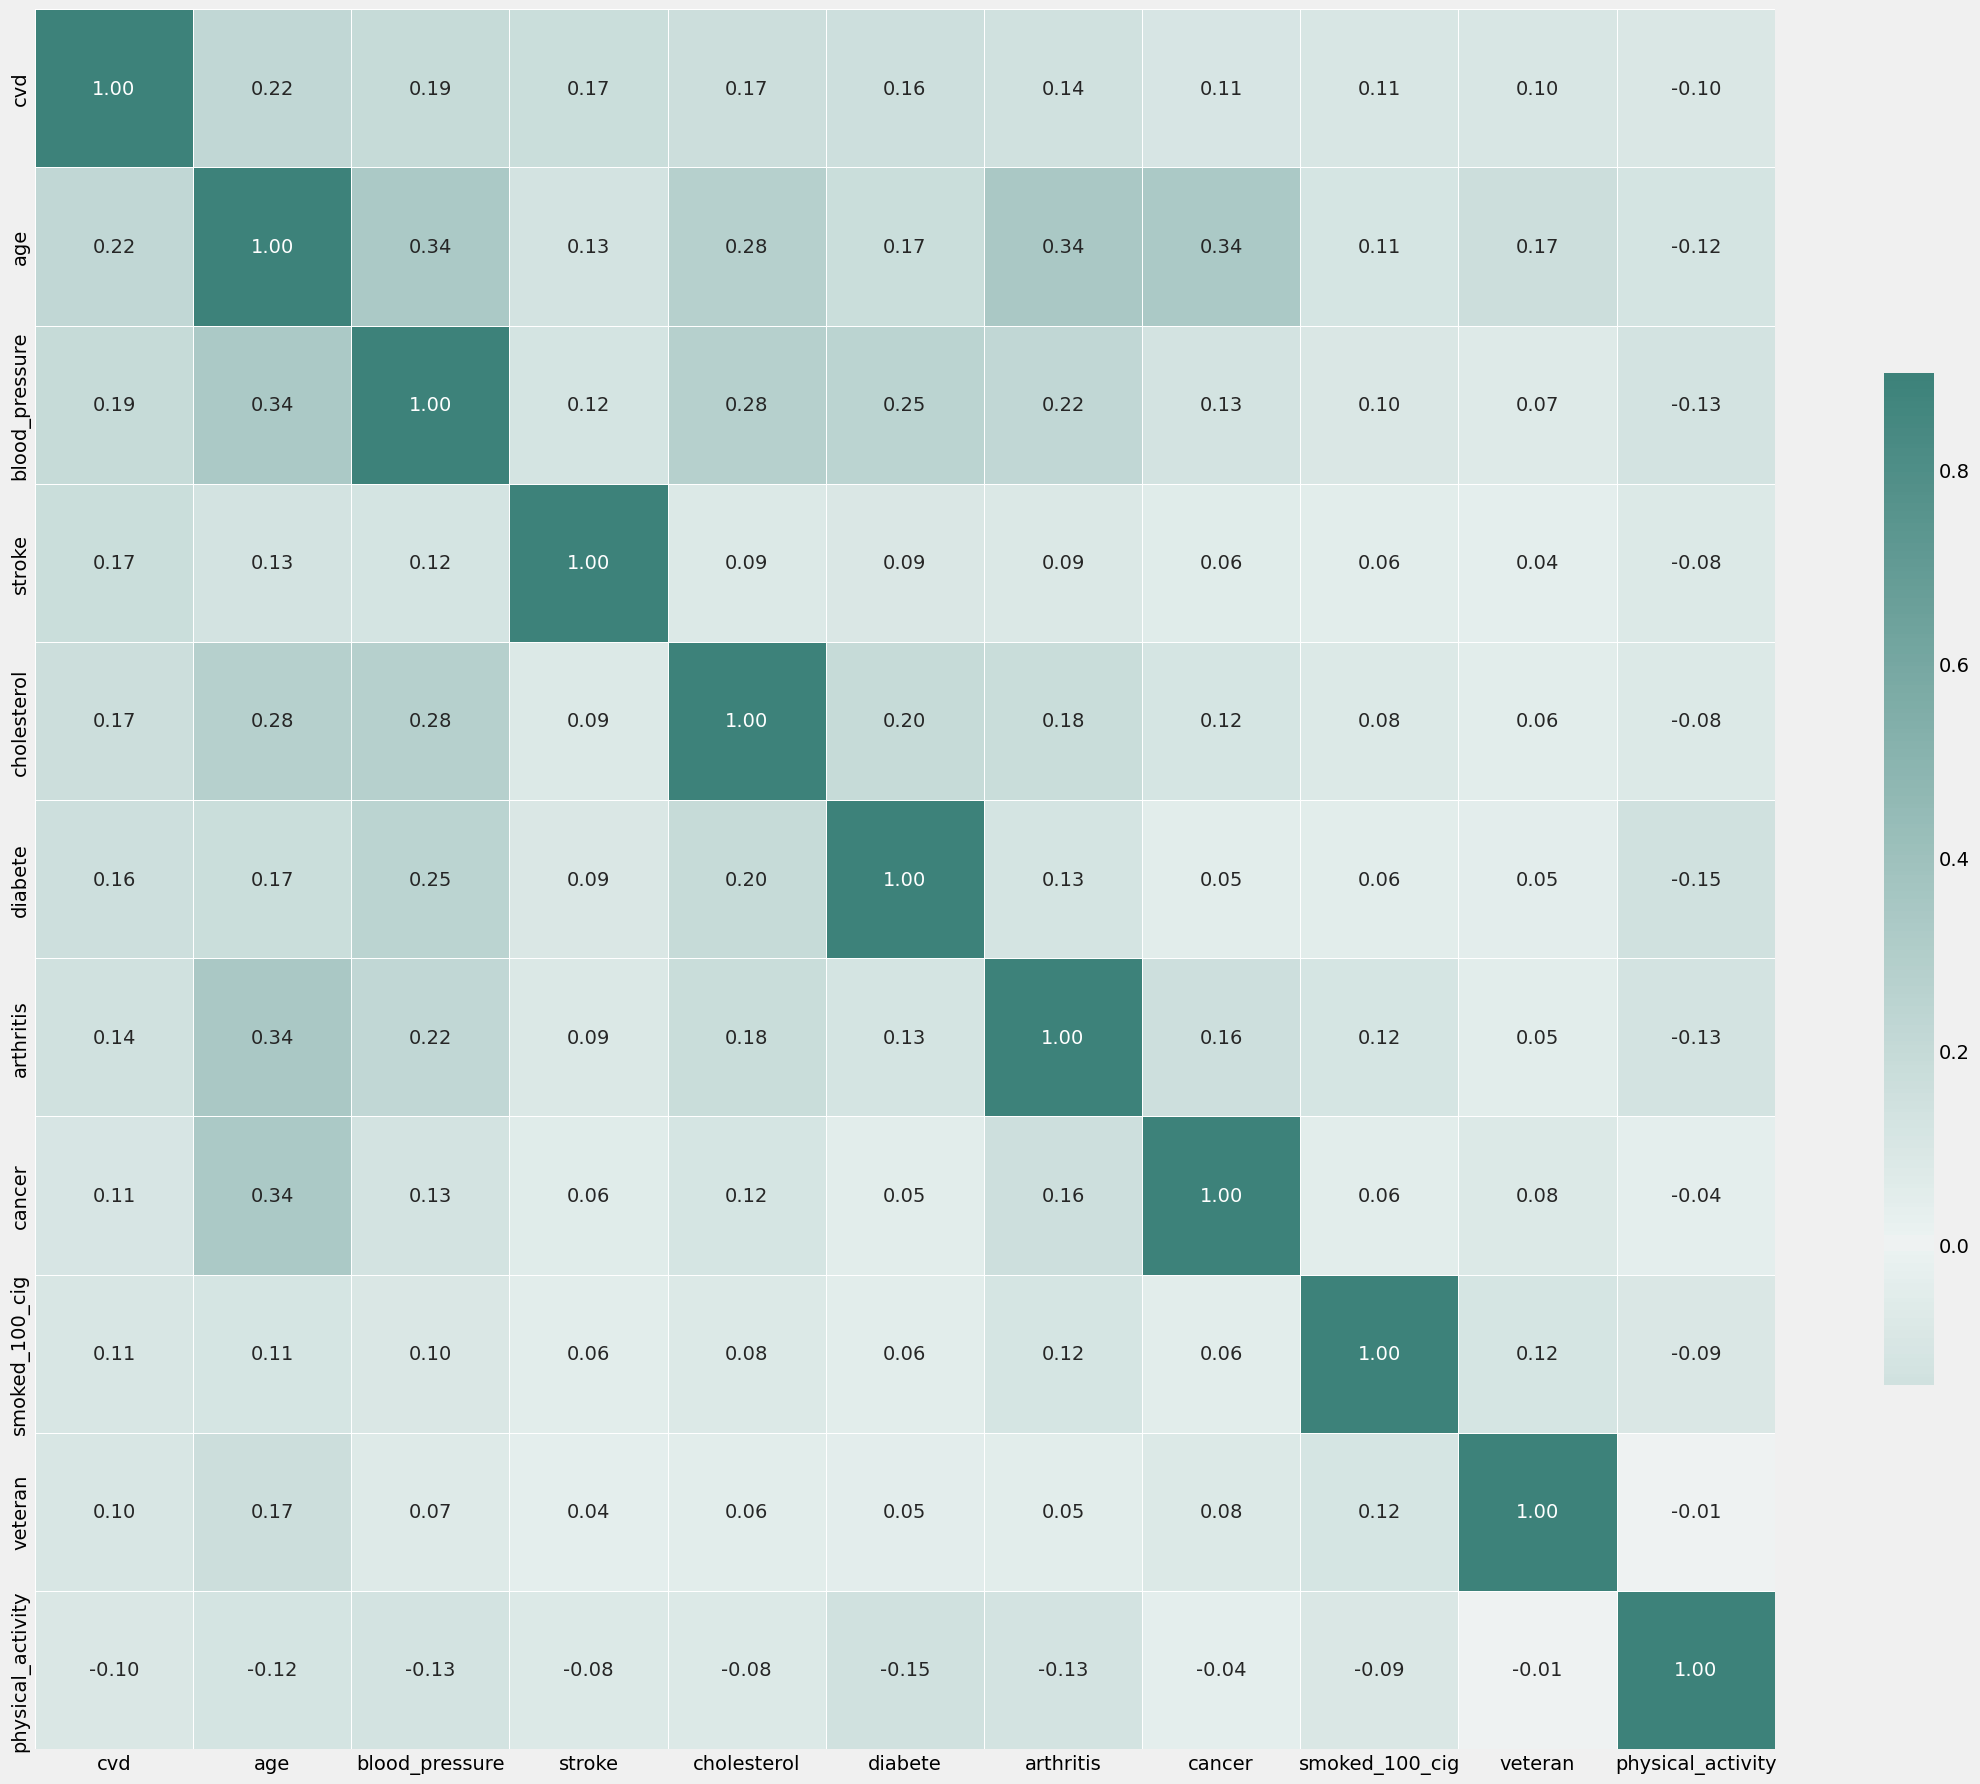

In [37]:
# Correlation (Spearman) after transforming the features to numerical

# corr_matrix_num = data1.corr(method='spearman', numeric_only=False)  # -> similar coef. as Cramer-V
corr_matrix_num = data1[chosen_cols].corr(method='spearman')
# display(corr_matrix_num.head())
# corr_matrix = abs(corr_matrix)   # don't care about the sign, only the absolute values
# by sorting by corr with target, when several cols are correlated it is the one the 
# most correlated with the target that will be kept
corr_matrix_num = corr_matrix_num.sort_values(by='cvd', ascending=False)
corr_matrix_num = corr_matrix_num[corr_matrix_num.index]

mask = np.zeros_like(corr_matrix_num, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Want diagonal elements as well?
# mask[np.diag_indices_from(mask)] = False

f, ax = plt.subplots(figsize=(25, 25))
cmap = sns.diverging_palette(180, 180, as_cmap=True)

sns_plot = sns.heatmap(corr_matrix_num,  cmap=cmap, vmax=.9, center=0, fmt='.2f',  # mask=mask,
                       square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True) #True)

# fig = sns_plot.get_figure()
# fig.savefig("features_heatmap.png")

In [39]:
data1[chosen_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272753 entries, 0 to 272752
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   physical_activity  272753 non-null  int64  
 1   blood_pressure     272753 non-null  int64  
 2   cholesterol        272753 non-null  int64  
 3   stroke             272753 non-null  int64  
 4   diabete            272753 non-null  int64  
 5   arthritis          272753 non-null  int64  
 6   veteran            272753 non-null  int64  
 7   income             272753 non-null  int64  
 8   smoked_100_cig     272753 non-null  int64  
 9   age                272753 non-null  float64
 10  cancer             272753 non-null  int64  
 11  cvd                272753 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 25.0 MB


In [49]:
print(data1.columns)

Index(['Unnamed: 0', 'state_id', 'sex', 'general_health', 'med_cost_issue',
       'physical_activity', 'blood_pressure', 'cholesterol', 'stroke',
       'asthma', 'depression', 'diabete', 'arthritis', 'education', 'veteran',
       'income', 'weight', 'height', 'smoked_100_cig', 'is_urban', 'race',
       'age', 'bmi', 'alcohol', 'fruits', 'vegetables', 'cvd', 'cancer'],
      dtype='object')


In [204]:
# Split the data

X = data1[chosen_cols].copy()
y = X.pop('cvd')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.8,   ###########
                                                    random_state=SEED, stratify=y)

# Data imbalanced
print(X_train.shape, y_test.shape)
print(sum(y_train)/len(y_train), sum(y_test)/len(y_test))
print(sum(y_train), sum(y_test))
display(X_train.head())


(54550, 12) (218203,)
0.08588450962419798 0.0858741630500039
4685 18738


,physical_activity,blood_pressure,cholesterol,stroke,diabete,arthritis,veteran,income,smoked_100_cig,age,cancer,sex
112658,0,1,0,0,0,0,0,5,0,52,0,1
239870,1,1,1,1,0,1,0,6,0,77,1,1
113262,1,0,0,0,0,0,0,6,0,21,0,0
177056,1,0,0,0,0,0,0,11,0,57,0,1
171461,1,0,0,0,0,0,0,11,0,42,0,1


In [205]:
# Scaling

scaler = StandardScaler().fit(X_train)   # RobustScaler   # StandardScaler   # MinMaxScaler  
X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns=X.columns)
display(X_train_scaled.head())

y_train = y_train.reset_index(drop=True) 
y_test = y_test.reset_index(drop=True)
display(y_train.head())

with pd.option_context('display.max_rows', None):
    display(X_train_scaled.describe().T)
    

,physical_activity,blood_pressure,cholesterol,stroke,diabete,arthritis,veteran,income,smoked_100_cig,age,cancer,sex
0,-1.863146,1.130716,-0.819525,-0.205920,-0.46275,-0.737128,-0.385349,-0.831582,-0.831927,-0.291493,-0.476504,1.078290
1,0.536727,1.130716,1.220219,4.856248,-0.46275,1.356616,-0.385349,-0.392271,-0.831927,1.221811,2.098619,1.078290
2,0.536727,-0.884396,-0.819525,-0.205920,-0.46275,-0.737128,-0.385349,-0.392271,-0.831927,-2.167991,-0.476504,-0.927395
3,0.536727,-0.884396,-0.819525,-0.205920,-0.46275,-0.737128,-0.385349,1.804282,-0.831927,0.011168,-0.476504,1.078290
4,0.536727,-0.884396,-0.819525,-0.205920,-0.46275,-0.737128,-0.385349,1.804282,-0.831927,-0.896815,-0.476504,1.078290


0    0
1    0
2    0
3    0
4    0
Name: cvd, dtype: int64

,count,mean,std,min,25%,50%,75%,max
physical_activity,54550.0,2.058034e-17,1.000009,-1.863146,0.536727,0.536727,0.536727,0.536727
blood_pressure,54550.0,2.839566e-17,1.000009,-0.884396,-0.884396,-0.884396,1.130716,1.130716
cholesterol,54550.0,-5.021342e-17,1.000009,-0.819525,-0.819525,-0.819525,1.220219,1.220219
stroke,54550.0,-3.894634e-17,1.000009,-0.205920,-0.205920,-0.205920,-0.205920,4.856248
diabete,54550.0,-3.152179e-17,1.000009,-0.462750,-0.462750,-0.462750,-0.462750,2.160993
arthritis,54550.0,9.534689e-17,1.000009,-0.737128,-0.737128,-0.737128,1.356616,1.356616
veteran,54550.0,7.932549e-17,1.000009,-0.385349,-0.385349,-0.385349,-0.385349,2.595052
income,54550.0,1.052463e-16,1.000009,-2.588824,-0.831582,0.047040,0.925661,1.804282
smoked_100_cig,54550.0,1.161877e-16,1.000009,-0.831927,-0.831927,-0.831927,1.202029,1.202029
age,54550.0,7.945574e-17,1.000009,-2.167991,-0.896815,0.011168,0.919151,1.524472



--- Logistic Regression Model ---
Scores on the train set:
   accuracy:  0.725
   AUC:  0.748
   precision:  0.207
   recall:  0.776
   f1:  0.326


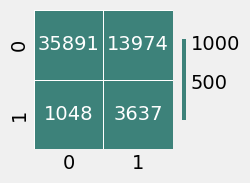

Scores on the test set:
   accuracy:  0.723
   AUC:  0.748
   precision:  0.206
   recall:  0.777
   f1:  0.325


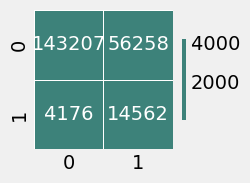


--- XG Boost Model ---
Scores on the train set:
   accuracy:  0.741
   AUC:  0.801
   precision:  0.232
   recall:  0.874
   f1:  0.367


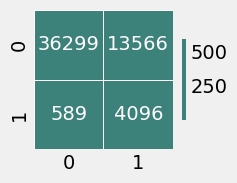

Scores on the test set:
   accuracy:  0.717
   AUC:  0.728
   precision:  0.196
   recall:  0.742
   f1:  0.31


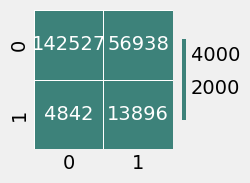


--- Random forest Model ---
Scores on the train set:
   accuracy:  0.904
   AUC:  0.892
   precision:  0.468
   recall:  0.879
   f1:  0.611


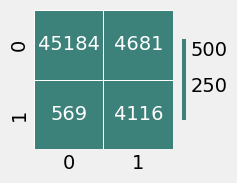

Scores on the test set:
   accuracy:  0.835
   AUC:  0.589
   precision:  0.194
   recall:  0.292
   f1:  0.233


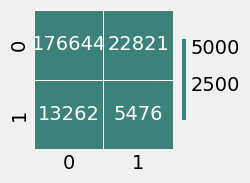


--- Extra Tree Model ---
Scores on the train set:
   accuracy:  0.868
   AUC:  0.911
   precision:  0.392
   recall:  0.963
   f1:  0.557


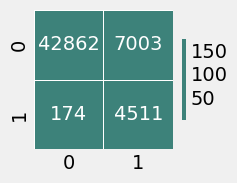

Scores on the test set:
   accuracy:  0.797
   AUC:  0.602
   precision:  0.175
   recall:  0.367
   f1:  0.237


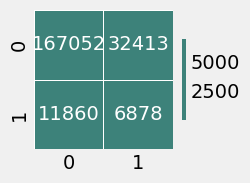

In [218]:
# Models

coef_imbalance = 11.64  # nb_negative / nb_positive

# LR doesn't converge if use RobustScaler ?
model_lr = LogisticRegression(random_state=SEED, n_jobs=-1, max_iter=1000, class_weight="balanced")
model_xgb = XGBClassifier(random_state=SEED, n_jobs=-1, scale_pos_weight=coef_imbalance)
model_rf = RandomForestClassifier(random_state=SEED, n_jobs=-1, class_weight="balanced")
model_xt = ExtraTreesClassifier(random_state=SEED, n_jobs=-1, class_weight="balanced")
model_cat = CatBoostClassifier(random_state=SEED, scale_pos_weight=coef_imbalance)

model_lr = fit_score_model(model_lr, X_train_scaled, y_train, X_test_scaled, y_test, "Logistic Regression")
model_xgb = fit_score_model(model_xgb, X_train_scaled, y_train, X_test_scaled, y_test, "XG Boost")
model_rf = fit_score_model(model_rf, X_train_scaled, y_train, X_test_scaled, y_test, "Random forest")
model_xt = fit_score_model(model_xt, X_train_scaled, y_train, X_test_scaled, y_test, "Extra Tree")
# model_cat = fit_score_model(model_cat, X_train_scaled, y_train, X_test_scaled, y_test, "Cat Boost")

# try F-score as imbalanced data but F2, F5 or F10 as FN>>FP


In [207]:
# Hyperparameters tuning for XGBoost


my_f2_scorer = make_scorer(fbeta_score, beta=1)
# by increasing beta FN decreases but FP increases (and F1 decreases)

from scipy.stats import loguniform     

param_distribution = { 
    'n_estimators': range(100, 300, 1),
    'learning_rate': loguniform(1e-4, 1e-1),
#     'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : range(2, 20),
    'subsample': [x / 100 for x in range(1, 101, 1)],
    'colsample_bytree': [x / 100 for x in range(1, 101, 1)],
    'nthread': [-1],
    'scale_pos_weight': [coef_imbalance]  # sum(negative instances) / sum(positive instances)   # f1=0.4 if 30 and 0.31 if 1
}

gs_xgb = RandomizedSearchCV(estimator=model_xgb, 
                            param_distributions=param_distribution, 
                            cv=5,    # stratified by default
                            scoring=my_f2_scorer,  # 'f1'
                            n_iter=10, 
                            n_jobs=-1,
                            return_train_score=True,
                            # random_state=SEED  # don't use it if want real randomness!!
)
gs_xgb.fit(X_train_scaled, y_train)

print(round(gs_xgb.best_score_, 3), gs_xgb.best_params_)
# print(gs_xgb.cv_results_.keys)
with pd.option_context('display.max_columns', None):
    display(pd.DataFrame(gs_xgb.cv_results_).sort_values(by='mean_test_score', ascending=False).drop('params', axis=1))


df_rank = pd.DataFrame(gs_xgb.cv_results_).sort_values(by='mean_test_score', ascending=False).drop('params', axis=1)[['mean_test_score', 'std_test_score']]
df_rank['best'] = df_rank['mean_test_score'] - df_rank['std_test_score']
display(df_rank.sort_values(by='best', ascending=False))


params = dict(**gs_xgb.best_params_, **{'random_state':SEED})
# print(params)
model_xgb = XGBClassifier(**params)  #, random_state=SEED)
model_xgb = fit_score_model(model_xgb, X_train_scaled, y_train, X_test_scaled, y_test, "Final test")


0.351 {'colsample_bytree': 0.86, 'learning_rate': 0.005258981906101871, 'max_depth': 18, 'n_estimators': 213, 'nthread': -1, 'scale_pos_weight': 11.64, 'subsample': 0.24}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_nthread,param_scale_pos_weight,param_subsample,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
5,5.743473,0.025073,0.453018,1.975933e-02,0.86,0.005259,18,213,-1,11.64,0.24,0.360507,0.348973,0.350077,0.361111,0.335753,0.351284,0.009270,1,0.447055,0.446263,0.442100,0.444273,0.446554,0.445249,0.001836
2,2.727300,0.018675,0.213799,1.162904e-02,0.59,0.010593,11,130,-1,11.64,0.88,0.329757,0.315408,0.312446,0.322119,0.317619,0.319470,0.006035,2,0.351869,0.355778,0.354660,0.355715,0.356298,0.354864,0.001589
4,2.808710,0.033358,0.062487,9.879630e-03,0.24,0.043278,3,252,-1,11.64,0.44,0.325405,0.311892,0.304742,0.320553,0.312030,0.314925,0.007249,3,0.314063,0.317352,0.319188,0.315045,0.318070,0.316744,0.001906
1,1.761489,0.034625,0.090757,4.593107e-03,0.66,0.006998,8,105,-1,11.64,0.24,0.319983,0.311720,0.303292,0.314156,0.315436,0.312918,0.005511,4,0.324548,0.326352,0.329068,0.326571,0.328062,0.326920,0.001549
8,1.833942,0.015931,0.040616,7.653293e-03,0.04,0.008995,16,176,-1,11.64,0.13,0.293082,0.285613,0.285457,0.290968,0.289730,0.288970,0.003003,5,0.286975,0.291119,0.290693,0.288977,0.290575,0.289668,0.001530
0,1.349788,0.036702,0.033111,9.770585e-04,0.13,0.00913,13,139,-1,11.64,0.73,0.286110,0.277637,0.276755,0.281325,0.277797,0.279925,0.003465,6,0.278049,0.280985,0.280492,0.279082,0.281502,0.280022,0.001274
9,2.152616,0.301520,0.128095,3.478907e-02,0.94,0.001586,9,112,-1,11.64,0.99,0.286314,0.279684,0.273882,0.277625,0.278511,0.279203,0.004051,7,0.299685,0.300832,0.305704,0.299663,0.298915,0.300960,0.002450
3,3.274229,0.032165,0.118722,7.653312e-03,0.88,0.000682,6,220,-1,11.64,0.39,0.273051,0.263713,0.260588,0.261625,0.263685,0.264533,0.004426,8,0.266137,0.268780,0.270876,0.268055,0.268353,0.268440,0.001517
6,1.892335,0.075364,0.053112,7.652417e-03,0.8,0.000105,4,131,-1,11.64,0.55,0.158184,0.158184,0.158184,0.158184,0.158184,0.158184,0.000000,9,0.158184,0.158184,0.158184,0.158184,0.158184,0.158184,0.000000
7,1.427788,0.015930,0.046863,3.568323e-07,0.71,0.000121,4,105,-1,11.64,0.45,0.158184,0.158184,0.158184,0.158184,0.158184,0.158184,0.000000,9,0.158184,0.158184,0.158184,0.158184,0.158184,0.158184,0.000000


,mean_test_score,std_test_score,best
5,0.351284,0.009270,0.342014
2,0.319470,0.006035,0.313435
4,0.314925,0.007249,0.307675
1,0.312918,0.005511,0.307406
8,0.288970,0.003003,0.285967
0,0.279925,0.003465,0.276460
9,0.279203,0.004051,0.275152
3,0.264533,0.004426,0.260106
6,0.158184,0.000000,0.158184
7,0.158184,0.000000,0.158184



--- Final test Model ---
Scores on the train set:
   accuracy:  0.83
   AUC:  0.802
   precision:  0.305
   recall:  0.767
   f1:  0.437
    [[41683  8182]
 [ 1090  3595]]
Scores on the test set:
   accuracy:  0.799
   AUC:  0.711
   precision:  0.237
   recall:  0.605
   f1:  0.34
    [[162929  36536]
 [  7398  11340]]


In [152]:
# Hyperparameters tuning for LR

# param_distribution = {
#     "C": np.logspace(-3, 3, 14), "penalty":["l2", None], "class_weight": ["balanced", None]
# }
param_distribution = [
  {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 
     "C": np.logspace(-3, 3, 14), "class_weight": ["balanced"]},  # , None
  {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'newton-cholesky', 'sag', 'saga', 'liblinear'], 
     "C": np.logspace(-3, 3, 14), "class_weight": ["balanced"]},
#   {'penalty': ['elasticnet'], 'solver': ['l1'], 
#      "C": np.logspace(-3, 3, 14), "class_weight": ["balanced", None]},
  {'penalty': [None], 'solver': ['newton-cg', 'lbfgs', 'newton-cholesky', 'sag', 'saga'], 
     "C": np.logspace(-3, 3, 14), "class_weight": ["balanced"]},  
]

gs_lr = RandomizedSearchCV(estimator=model_lr, 
                            param_distributions=param_distribution, 
                            cv=5,    # stratified by default
                            scoring=my_f2_scorer,  # 'f1' 
                            n_iter=30, 
                            n_jobs=-1,
                            # random_state=SEED
)
gs_lr.fit(X_train_scaled, y_train)

print(round(gs_lr.best_score_, 3), gs_lr.best_params_)
display(pd.DataFrame(gs_lr.cv_results_).sort_values(by='mean_test_score', ascending=False).drop('params', axis=1))

# 0.346  with all the columns

params = dict(**gs_lr.best_params_, **{'random_state':SEED})
# print(params)
model_lr = LogisticRegression(**params)  # random_state=SEED)
model_lr = fit_score_model(model_lr, X_train_scaled, y_train, X_test_scaled, y_test, "Final test")


0.522 {'solver': 'sag', 'penalty': 'l2', 'class_weight': 'balanced', 'C': 0.0028942661247167516}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_solver,param_penalty,param_class_weight,param_C,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
13,0.768570,0.081711,0.009372,7.652514e-03,sag,l2,balanced,0.002894,0.537911,0.510934,0.512893,0.525799,0.523001,0.522108,0.009736,1
7,0.212450,0.012497,0.009372,7.652397e-03,lbfgs,l2,balanced,0.008377,0.539651,0.508890,0.511067,0.526906,0.523742,0.522051,0.011225,2
18,1.140355,0.051337,0.015621,5.091228e-07,sag,l2,balanced,0.024245,0.539980,0.508961,0.511211,0.527201,0.522843,0.522039,0.011291,3
17,0.621730,0.038771,0.012497,6.248450e-03,newton-cg,l2,balanced,0.024245,0.539980,0.508961,0.511211,0.527201,0.522843,0.522039,0.011291,3
8,0.165586,0.007652,0.012496,6.248093e-03,newton-cholesky,l2,balanced,0.024245,0.539980,0.508961,0.511211,0.527201,0.522843,0.522039,0.011291,3
16,0.187456,0.009878,0.012496,6.248164e-03,lbfgs,l2,balanced,0.07017,0.539033,0.509032,0.511211,0.527054,0.522695,0.521805,0.010959,6
5,1.455906,0.134888,0.006248,7.652203e-03,sag,l2,balanced,0.203092,0.538802,0.508546,0.510995,0.527054,0.522399,0.521559,0.011038,7
22,2.180491,0.209007,0.015609,2.532647e-05,liblinear,l1,balanced,119.377664,0.538725,0.508546,0.511067,0.527054,0.522399,0.521558,0.011000,8
20,1.140355,0.052279,0.006249,7.652845e-03,saga,l1,balanced,4.923883,0.538725,0.508546,0.511067,0.527054,0.522399,0.521558,0.011000,8
24,2.099504,0.308435,0.012497,1.169027e-02,liblinear,l1,balanced,41.246264,0.538725,0.508546,0.511067,0.527054,0.522399,0.521558,0.011000,8


In [ ]:

# Better use Cross-Validation instead of one test set but would make it complicated (as need to do oversampling only on train set inside each fold) 
# Probably best to use pipelines

# To have a better idea, rerun the program 3 times with different seeds and average the 3 f1 scores on the final test set.
#   is it a pb that for each seed, the hyperparameters are not the same?